In [1]:
import sys
import numpy
from scipy.fftpack import dct
import scipy.io.wavfile
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import librosa
import librosa.display

from pydub import AudioSegment
import glob

In [2]:
recording_list = glob.glob("*.mp3")
print(recording_list)

for record in recording_list:
    signal, sample_rate = librosa.load('CrownedEagle.mp3',sr=None,mono=True) #librosa automatically converts to mono, set here explicitly
    print("Sampling rate: " + str(sample_rate))
    converted_name = record[:-3] + "wav"
    librosa.output.write_wav(converted_name, signal, sample_rate)

['CrownedEagle.mp3']
Sampling rate: 44100


In [46]:
sample_rate, signal = scipy.io.wavfile.read('CrownedEagle.wav')
nyquist = sample_rate/2;
signal_length = len(signal)
total_time = signal_length/sample_rate
print("Sampling rate: " + str(sample_rate))
print("Nyquist sampling rate: " + str(nyquist))
print("Number of data points: " + str(signal_length))
print("Approximate length: " + str(total_time))

Sampling rate: 44100
Nyquist sampling rate: 22050.0
Number of data points: 791257
Approximate length: 17.94233560090703


In [4]:
time_step = 1/sample_rate
time_axis = numpy.arange(0, signal_length/sample_rate, time_step)
print("Time Step Size: " + str(time_step))
print(time_axis)

Time Step Size: 2.2675736961451248e-05
[0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 1.79422676e+01
 1.79422902e+01 1.79423129e+01]


(0, 17.94233560090703)

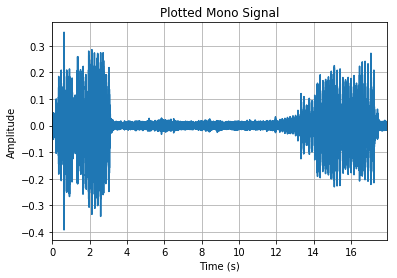

In [5]:
plt.figure(1)
plt.plot(time_axis, signal)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("Plotted Mono Signal")
plt.grid(True)
plt.xlim([0, total_time])

In [6]:
pre_emphasis = 0.97
signal_emphasized = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
print(signal_emphasized)

[ 0.0007782   0.00025223  0.00025909 ... -0.00052383 -0.00301559
  0.00267304]


(0, 17.94233560090703)

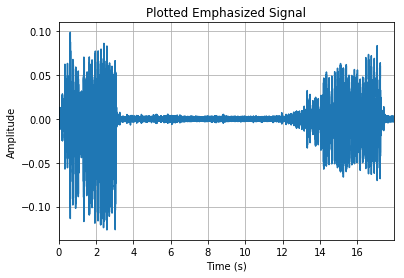

In [7]:
plt.figure(2)
plt.plot(time_axis, signal_emphasized)
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.title("Plotted Emphasized Signal")
plt.grid(True)
plt.xlim([0, total_time])

In [8]:
#Want 40ms frames with 50% overlap
frame_size = 0.040
overlap = 0.5

frame_length = int(frame_size * sample_rate)
signal_length_new = int(numpy.trunc((signal_length/frame_length)+1)*frame_length)
padded_bits = signal_length_new-signal_length
signal_processed = numpy.pad(signal_emphasized, (0, int(padded_bits)), 'constant')

print("Frame length: " + str(frame_length))
print("Number of padded bits at end: " + str(padded_bits))
print("Old signal length: " + str(signal_length))
print("New signal length: " + str(signal_length_new))

Frame length: 1764
Number of padded bits at end: 779
Old signal length: 791257
New signal length: 792036


Text(0.5,1,'MFCC')

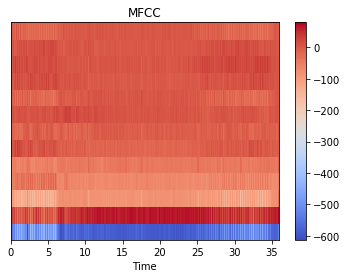

In [9]:
mfccs = librosa.feature.mfcc(y=signal_emphasized, sr=sample_rate, n_mfcc=13) 
plt.figure(3)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

In [10]:
start = 0
end = 1764
extract = signal_processed[start:end]
print(extract[-1])
print(signal_processed[1763])
print(signal_processed[1764])
print(signal_processed[792035])

-0.00047164923
-0.00047164923
4.5471126e-05
0.0


In [11]:
factor = int(frame_length * overlap)   #Frame step?
print("Overlap frame amount: " + str(factor))
index_start = 0
index_end = frame_length
extract = signal_processed[index_start:index_end]
size = (factor,frame_length)       #Change factor here if you want to make the overlap amount dynamic
extracted = numpy.zeros(size)
for i in range(0,factor):          #Change factor here is you want to make the overlap amount dynamic
    extracted[i] = signal_processed[index_start:index_end]
    index_start = index_start + factor
    index_end = index_end + factor
    
if (extract == extracted[0]).all():
    print("Arrays contain the correct elements")

Overlap frame amount: 882
Arrays contain the correct elements


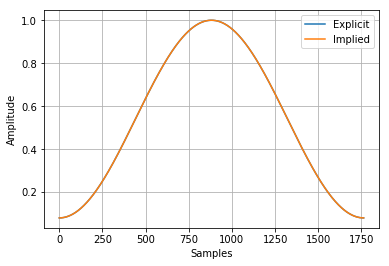

In [12]:
window_size = numpy.arange(frame_length)
window_function_explicit = 0.54 - 0.46 * numpy.cos((2 * numpy.pi * window_size) / (frame_length-1))
window_function_implied = numpy.hamming(frame_length)
plt.figure(4)
plt.plot(window_function_explicit, label='Explicit')
plt.plot(window_function_implied, label='Implied')
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.legend()
plt.grid(True)
plt.savefig('hamming_window.jpg', bbox_inches='tight', dpi=200)
plt.show()

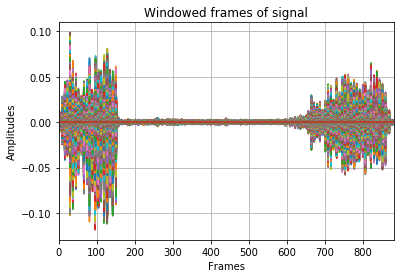

In [19]:
extracted = extracted * numpy.hamming(frame_length)
plt.figure(5)
plt.plot(extracted)
plt.xlabel("Frames")
plt.ylabel("Amplitudes")
plt.title("Windowed frames of signal")
plt.grid(True)
plt.xlim([0, 881])
plt.show()

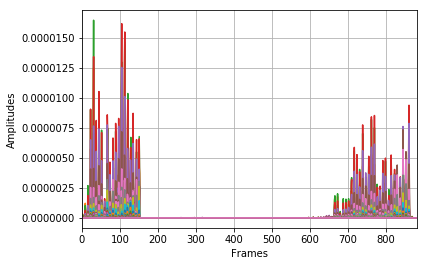

(882, 257)
(882, 257)


In [49]:
NFFT = 512
magnitude = numpy.absolute(numpy.fft.rfft(extracted, NFFT))  
power_spectrum = ((1.0 / NFFT) * ((mag_frames) ** 2)) 

plt.figure(6)
plt.plot(power_spectrum)
#plt.plot(magnitude)
plt.xlabel("Frames")
plt.ylabel("Amplitudes")
plt.grid(True)
plt.xlim([0, 881])
plt.show()

print(magnitude.shape)
print(power_spectrum.shape)

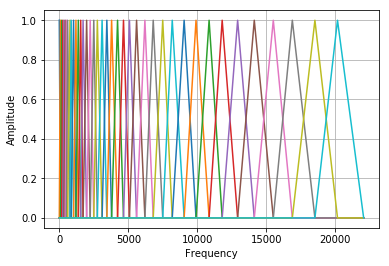

In [80]:
nfilt = 40

freq_low_mel = 0
freq_high_mel = (2595.0 * numpy.log10(1.0 + nyquist/700.0)) 

mel_scale = numpy.linspace(freq_low_mel, freq_high_mel, nfilt + 2)  #Need 2 additional points not counting the start and end frequencies
hz_scale = (700.0 * (10.0 ** (mel_scale / 2595.0) - 1.0)) 


bin = numpy.floor((NFFT + 1) * hz_scale / sample_rate) 

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))

for m in range(1, nfilt+1):
    f_previous = int(bin[m-1])
    f_current = int(bin[m])
    f_next = int(bin[m+1])
    
    for k in range(f_previous, f_current):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_current, f_next):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

mel_filter_scale = numpy.linspace(freq_low_mel, (sample_rate / 2), 257)
        
        
plt.figure(7)
plt.plot(mel_filter_scale, fbank.T)   #fbank.T means transpose
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.grid(True)
plt.show()

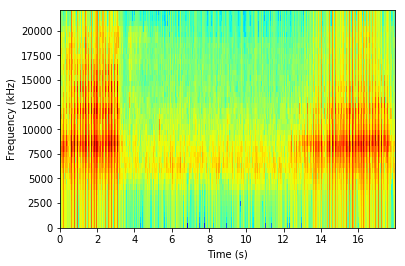

In [130]:
#INVESTIGATION TEAM GO!

# Features
filter_banks = numpy.dot(power_spectrum, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks) # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

#plt.imshow(numpy.flipud(filter_banks.T), cmap=cm.jet, aspect=0.2, extent=[0,total_time,0,4])
flipped = numpy.flipud(filter_banks.T)
plt.imshow(flipped, cmap=cm.jet, aspect='auto', extent=[0,total_time,0,nyquist])  #Not 100% about this image processing
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.show()

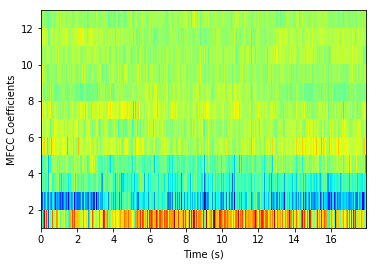

In [114]:
numceps = 13

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : numceps]
#mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')

plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, extent=[0,total_time,1,numceps])
plt.ylabel('MFCC Coefficients')
plt.xlabel('Time (s)')
plt.show()

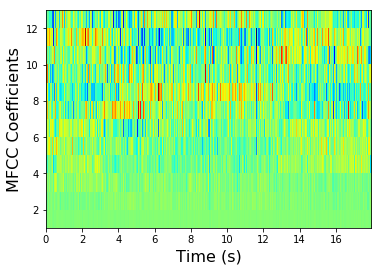

[[-207.12781518 -207.18218881 -207.34164607 ... -199.32733603
  -200.19590117 -200.71388509]
 [-220.4353314  -219.89590584 -218.38119867 ... -189.76092156
  -190.38176945 -191.05233723]
 [-165.73042562 -165.67918892 -165.52314662 ... -177.15605114
  -180.1703344  -180.15125446]
 ...
 [-182.34049318 -182.22763361 -181.88600564 ... -225.25005722
  -227.25351757 -225.86394247]
 [-179.7827483  -179.70295777 -179.44801633 ... -227.11828181
  -223.06592432 -221.91687827]
 [-208.47100593 -208.1877299  -207.1794727  ... -203.6410104
  -206.02677872 -204.23295611]]


In [131]:
cep_lifter = 22

# Lifter
if cep_lifter > 0:
    (nframes, ncoeff) = numpy.shape(mfcc)
    n = numpy.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    mfcc *= lift
    

plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, extent=[0,total_time,1,numceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('mfcc_liftered.jpg', bbox_inches='tight', dpi=200)
plt.show()
print(filter_banks)

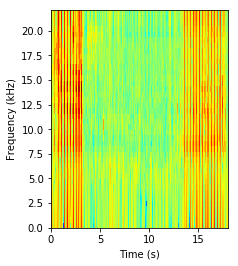

[[-10.68889231 -12.01014297 -13.45330619 ...   5.06230779   6.02634
    5.42366511]
 [-23.99640853 -24.72385999 -24.49285878 ...  14.62872226  15.84047172
   15.08521297]
 [ 30.70849725  29.49285692  28.36519326 ...  27.23359268  26.05190676
   25.98629574]
 ...
 [ 14.09842969  12.94441223  12.00233424 ... -20.8604134  -21.03127641
  -19.72639227]
 [ 16.65617457  15.46908808  14.44032355 ... -22.72863799 -16.84368316
  -15.77932807]
 [-12.03208306 -13.01568406 -13.29113282 ...   0.74863342   0.19546244
    1.90459409]]


In [132]:
filter_banks -= (numpy.mean(filter_banks, axis=0) + numpy.finfo(float).eps)
plt.imshow(numpy.flipud(filter_banks.T), cmap=cm.jet, extent=[0,total_time,0,22.05])
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (s)')
plt.show()
print(filter_banks)

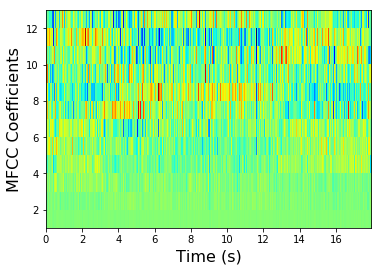

(882, 12)


In [133]:
mfcc -= (numpy.mean(mfcc, axis=0) + numpy.finfo(float).eps)

plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, extent=[0,total_time,1,numceps])
plt.ylabel('MFCC Coefficients', fontsize=16)
plt.xlabel('Time (s)', fontsize=16)
plt.savefig('mfcc.jpg', bbox_inches='tight', dpi=200)
plt.show()
print(mfcc.shape)